In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import umap.umap_ as umap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

F:\ANACONDA\envs\py_sp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
greeks = pd.read_csv('greeks.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(617, 58) (5, 57)


In [3]:
train['EJ'].replace({"A": 0,"B":1}, inplace=True)
times = greeks['Epsilon'].copy()
times[greeks['Epsilon'] != 'Unknown'] = greeks['Epsilon'][greeks['Epsilon'] != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks['Epsilon'] == 'Unknown'] = np.nan
train['time']=times

In [20]:
X=train.drop(['Class','Id'],axis=1)
y=greeks['Alpha']
unique_classes, y = np.unique(y, return_inverse=True)

In [21]:
X=X.fillna(np.nan)
X=X.fillna(-100)

In [22]:

umap_model = umap.UMAP(n_neighbors=10, random_state=1)
embedding = umap_model.fit_transform(X) # перевод всех признаков в двумерное пространство
colors = ["r", "g", "b", "yellow", "pink", "orange", "c", "m", 'aquamarine', 'mediumseagreen','black','dimgray','silver','rosybrown','firebrick','tomato','sandybrown','gold','lawngreen','turquoise','dodgerblue','slateblue','navy','fuchsia','orchid']

F:\ANACONDA\envs\py_sp\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
def umap_cluster(clusters):  
    seed =1
    kmeans = KMeans(n_clusters=clusters, random_state=seed)
    kmeans.fit(embedding) #кластеризация признаков из двумерного пространства на 4 кластера 
    labels = kmeans.predict(embedding) # получение метки кластера 1- 4
    labels_color = [colors[i] for i in labels]

    plt.scatter(embedding[:, 0], embedding[:, 1], color=labels_color)
    plt.title("Результаты кластеризации KMeans")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    return labels

F:\ANACONDA\envs\py_sp\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
F:\ANACONDA\envs\py_sp\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


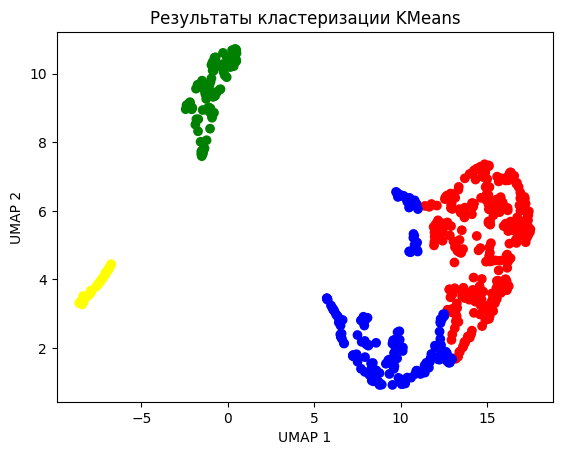

F:\ANACONDA\envs\py_sp\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
F:\ANACONDA\envs\py_sp\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


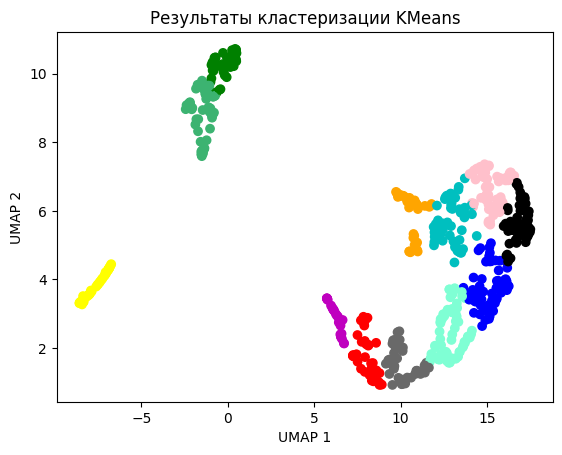

In [24]:
labels_4 = umap_cluster(4)
labels_12 = umap_cluster(12)

In [25]:
# NEW FEATURES
X['emb0']=embedding[:, 0]
X['emb1']=embedding[:, 1]

X['clusters_4']=labels_4
X['clusters_12']=labels_12

### Modeling

In [26]:
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from tabpfn import TabPFNClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import log_loss
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from imblearn.combine import SMOTETomek

In [41]:

seed =1

In [27]:
bad_cols=['AF', 'AH', 'AR', 'AX', 'BC', 'CF', 'CS', 'CU', 'CW ', 'DI', 'EE', 'EH', 'EJ', 'EL', 'FI']+['GI']

In [28]:
X=X.drop(columns=bad_cols)
cols=X.columns

X=np.array(X)
y=np.array(y)

In [ ]:
pt = PowerTransformer()
X=pt.fit_transform(X)

In [30]:
X=pd.DataFrame(X,columns=cols)
X=np.array(X)

In [38]:
def reweight(p,class_0_est_instances,others_est_instances):
    new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
    return new_p / np.sum(new_p,axis=1,keepdims=1)

In [46]:
class Model:
    def __init__(self):
        
        self.cb=CatBoostClassifier(
            iterations=1000,
            random_state=seed
            )
        
        self.xgb_clf=xgb.XGBClassifier(max_depth = 2,
                                       n_estimators = 150,
                                       random_state = seed,
                                      )

        self.tabPFN = TabPFNClassifier(N_ensemble_configurations=64, device='cpu')
        
    def fit(self,X_train,y_train, X_val, y_val):
        
        self.cb.fit(X_train,y_train,eval_set=(X_val, y_val), verbose=100) # Catboost
        self.xgb_clf.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=100) # XGB
        self.tabPFN.fit(X_train,y_train,overwrite_warning=True) #tabPFN

    def predict_proba(self,X):
        
        pred_val1=self.cb.predict_proba(X)[:,0]
        pred_val2=self.xgb_clf.predict_proba(X)[:,0]
        pred_val4=self.tabPFN.predict_proba(X)[:,0]
        
        avg_pred=(pred_val1+pred_val2+pred_val4)/3
        
        avg_pred=avg_pred.reshape(-1,1)
        avg_pred=np.append(avg_pred,1-avg_pred,axis=1)
        inst0=avg_pred[:,0].sum()
        inst1=avg_pred[:,1].sum()
        avg_pred= reweight(avg_pred,inst0,inst1)
        return avg_pred

In [47]:
def balanced_log_loss(y_true, y_pred, **kwargs):
    y_pred_clipped = np.clip(y_pred.reshape(-1), 1e-15, 1-1e-15)
    y_true_ = y_true.reshape(-1).astype(np.float64)
    class_counts = np.bincount(y_true.astype(np.int64))
    balanced_log_loss_score = (- ((1 - y_true_) * np.log(1 - y_pred_clipped)).sum() / class_counts[0]
                               - (y_true_ * np.log(y_pred_clipped)).sum() / class_counts[1]) / 2
    return balanced_log_loss_score

In [50]:
def train_(splits=4):
    
    losses=[]
    best_loss=1e9
    
    #n=0
    
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    avg_loss=0
    
    
    for train_index, val_index in skf.split(X, y):
           
        model=Model()
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        ros = RandomOverSampler(random_state=seed)
        X_train, y_train = ros.fit_resample(X_train, y_train) 
        
        model.fit(X_train,y_train,X_val, y_val)
        
        avg_pred = model.predict_proba(X_val)
        
        y_val=pd.Series(y_val)
        y_val.replace({
            0:0,
            1:1,
            2:1,
            3:1
        }, inplace=True)

        loss=balanced_log_loss(np.array(y_val),avg_pred[:,1])
        losses.append(loss)
        
        avg_loss+=loss

    print(avg_loss/splits)
    best_loss=avg_loss/splits
    return best_loss

In [51]:
b = train_(4)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Learning rate set to 0.108896
0:	learn: 1.2120027	test: 1.2670337	best: 1.2670337 (0)	total: 26.2ms	remaining: 26.1s
100:	learn: 0.0410182	test: 0.2045043	best: 0.2045043 (100)	total: 2.11s	remaining: 18.8s
200:	learn: 0.0148597	test: 0.1702180	best: 0.1702180 (200)	total: 4.12s	remaining: 16.4s
300:	learn: 0.0085271	test: 0.1658705	best: 0.1653339 (289)	total: 6.05s	remaining: 14s
400:	learn: 0.0058867	test: 0.1634325	best: 0.1633900 (387)	total: 7.89s	remaining: 11.8s
500:	learn: 0.0044359	test: 0.1631696	best: 0.1621422 (482)	total: 9.79s	remaining: 9.75s
600:	learn: 0.0035316	test: 0.1646584	best: 0.1621422 (482)	total: 11.6s	remaining: 7.73s
700:	learn: 0.0029400	test: 0.1654257	best: 0.1621422 (482)	total: 13.7s	remaining: 5.84s
800:	learn: 0.0024684	test: 0.1663404	best: 0.1621422 (482)	total: 15.8s	remaining: 3.94s
900:	learn: 0.0021270	test: 0.1655937	best: 0.1621422 (482)	total: 18s	

F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Learning rate set to 0.10889
0:	learn: 1.2130125	test: 1.2462935	best: 1.2462935 (0)	total: 24ms	remaining: 24s
100:	learn: 0.0417193	test: 0.2552631	best: 0.2548033 (94)	total: 2.36s	remaining: 21s
200:	learn: 0.0155656	test: 0.2322984	best: 0.2322943 (198)	total: 4.66s	remaining: 18.5s
300:	learn: 0.0090465	test: 0.2331392	best: 0.2309638 (272)	total: 6.7s	remaining: 15.6s
400:	learn: 0.0062315	test: 0.2378138	best: 0.2309638 (272)	total: 8.7s	remaining: 13s
500:	learn: 0.0046348	test: 0.2388553	best: 0.2309638 (272)	total: 10.8s	remaining: 10.7s
600:	learn: 0.0036077	test: 0.2415132	best: 0.2309638 (272)	total: 12.9s	remaining: 8.56s
700:	learn: 0.0029981	test: 0.2434243	best: 0.2309638 (272)	total: 14.9s	remaining: 6.37s
800:	learn: 0.0025370	test: 0.2456755	best: 0.2309638 (272)	total: 20.2s	remaining: 5.01s
900:	learn: 0.0021857	test: 0.2462146	best: 0.2309638 (272)	total: 24.8s	remainin

F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Learning rate set to 0.108896
0:	learn: 1.2051466	test: 1.2311197	best: 1.2311197 (0)	total: 102ms	remaining: 1m 42s
100:	learn: 0.0431265	test: 0.1883052	best: 0.1883052 (100)	total: 2.29s	remaining: 20.3s
200:	learn: 0.0168895	test: 0.1509065	best: 0.1509003 (199)	total: 4.49s	remaining: 17.9s
300:	learn: 0.0094696	test: 0.1417291	best: 0.1412783 (296)	total: 6.61s	remaining: 15.3s
400:	learn: 0.0065799	test: 0.1394656	best: 0.1391238 (392)	total: 8.78s	remaining: 13.1s
500:	learn: 0.0049740	test: 0.1366906	best: 0.1366906 (500)	total: 11s	remaining: 11s
600:	learn: 0.0040391	test: 0.1366417	best: 0.1362543 (512)	total: 13s	remaining: 8.64s
700:	learn: 0.0033946	test: 0.1344362	best: 0.1343257 (694)	total: 15s	remaining: 6.41s
800:	learn: 0.0028854	test: 0.1340238	best: 0.1338701 (750)	total: 17s	remaining: 4.21s
900:	learn: 0.0024878	test: 0.1339958	best: 0.1336750 (880)	total: 19s	remainin

F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Learning rate set to 0.108896
0:	learn: 1.2115230	test: 1.2851470	best: 1.2851470 (0)	total: 88.1ms	remaining: 1m 28s
100:	learn: 0.0381151	test: 0.4163067	best: 0.4163067 (100)	total: 5.73s	remaining: 51s
200:	learn: 0.0157772	test: 0.4149492	best: 0.4080153 (172)	total: 8.19s	remaining: 32.5s
300:	learn: 0.0088274	test: 0.4216057	best: 0.4080153 (172)	total: 10.8s	remaining: 25s
400:	learn: 0.0060329	test: 0.4380514	best: 0.4080153 (172)	total: 13.4s	remaining: 20s
500:	learn: 0.0045397	test: 0.4478987	best: 0.4080153 (172)	total: 16.1s	remaining: 16.1s
600:	learn: 0.0035621	test: 0.4564890	best: 0.4080153 (172)	total: 18.5s	remaining: 12.3s
700:	learn: 0.0028936	test: 0.4588317	best: 0.4080153 (172)	total: 21.2s	remaining: 9.04s
800:	learn: 0.0024981	test: 0.4627409	best: 0.4080153 (172)	total: 23.8s	remaining: 5.91s
900:	learn: 0.0021711	test: 0.4693846	best: 0.4080153 (172)	total: 26.8s	r

F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
F:\ANACONDA\envs\py_sp\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


0.18724014177317805
